In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, Conv2D, Flatten, Concatenate, Reshape, TimeDistributed
from tensorflow.keras.models import Model
from tqdm.keras import TqdmCallback
import librosa
import soundfile as sf
from tensorflow.keras.models import load_model

In [2]:
def process_audio(audio_path, duration=30, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
    # Load audio file
    y, sr = librosa.load(audio_path, duration=duration, sr=sr)

    # Compute mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalize spectrogram
    mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())

    # Downsample waveform to match spectrogram time resolution
    waveform = librosa.resample(y, orig_sr=sr, target_sr=sr//hop_length)

    # Ensure both have the same length
    min_length = min(mel_spec_db.shape[1], len(waveform))
    mel_spec_db = mel_spec_db[:, :min_length]
    waveform = waveform[:min_length]

    # Normalize waveform
    waveform = (waveform - waveform.min()) / (waveform.max() - waveform.min())

    return mel_spec_db, waveform

In [3]:
# Test the function

audio_file = "/content/DRAGANOV - 3DABI - OFFICIAL INSTRUMENTAL.mp3"
mel_spec, waveform = process_audio(audio_file)
print(f"Mel spectrogram shape: {mel_spec.shape}")
print(f"Waveform shape: {waveform.shape}")

Mel spectrogram shape: (128, 1290)
Waveform shape: (1290,)


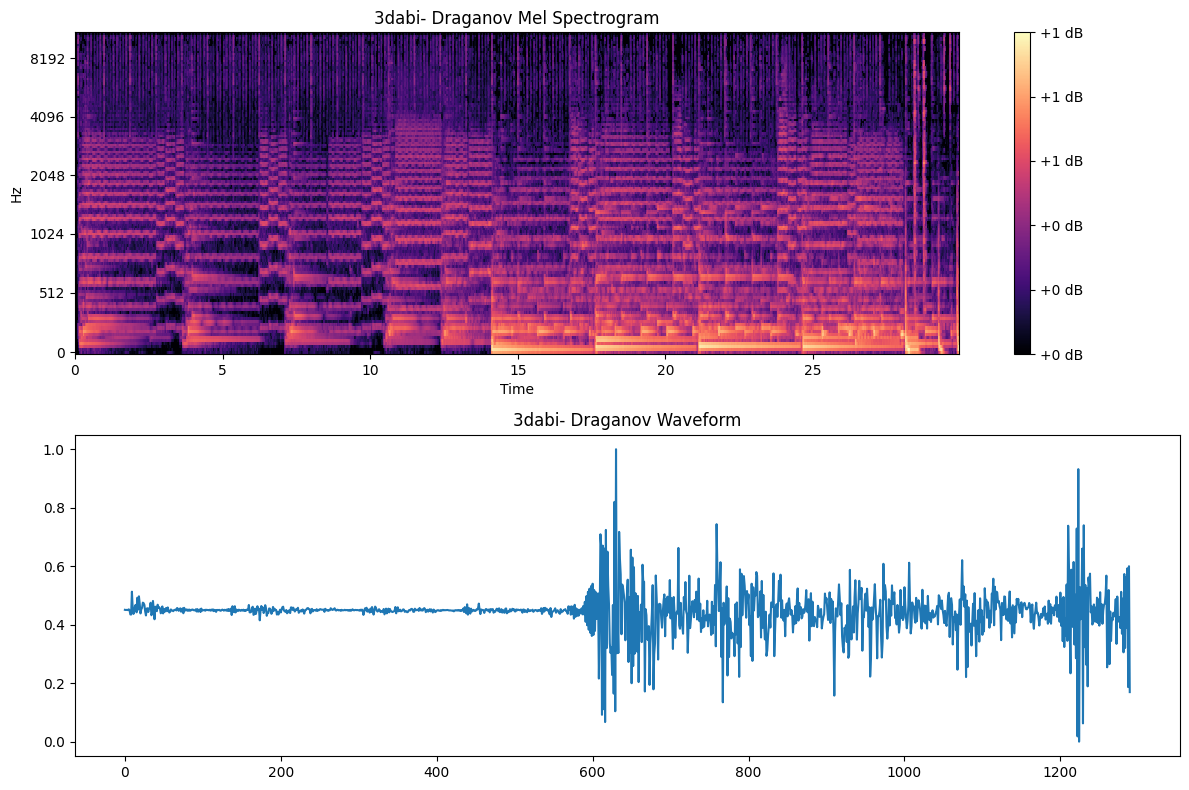

In [5]:
# Visualize

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('3dabi- Draganov Mel Spectrogram')

plt.subplot(2, 1, 2)
plt.plot(waveform)
plt.title('3dabi- Draganov Waveform')
plt.tight_layout()
plt.show()

We tested it over one song, now let's do it over our whole dataset

In [4]:
def process_audio_files(directory, max_files=None):
    processed_data = []
    audio_files = [f for f in os.listdir(directory) if f.endswith('.mp3') or f.endswith('.wav')]

    if max_files:
        audio_files = audio_files[:max_files]

    for audio_file in tqdm(audio_files, desc="Processing audio files"):
        file_path = os.path.join(directory, audio_file)
        mel_spec, waveform = process_audio(file_path)
        processed_data.append((mel_spec, waveform))

    return processed_data


In [5]:
# Usage

audio_directory = "//content/draga-music"
processed_data = process_audio_files(audio_directory, max_files=10)  # Process up to 10 files
print(f"Processed {len(processed_data)} audio files")

Processing audio files: 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

Processed 8 audio files


In [6]:
# Creating the sequences for the model

def prepare_sequences(processed_data, seq_length=128):
    X_mel, X_wave, y_mel, y_wave = [], [], [], []

    for mel_spec, waveform in processed_data:
        for i in range(0, mel_spec.shape[1] - seq_length - 1, seq_length // 2):
            X_mel.append(mel_spec[:, i:i+seq_length])
            X_wave.append(waveform[i:i+seq_length])
            y_mel.append(mel_spec[:, i+1:i+seq_length+1])
            y_wave.append(waveform[i+1:i+seq_length+1])

    return np.array(X_mel), np.array(X_wave), np.array(y_mel), np.array(y_wave)

In [12]:
# Usage

X_mel, X_wave, y_mel, y_wave = prepare_sequences(processed_data)
print(f"Input shapes: Mel - {X_mel.shape}, Wave - {X_wave.shape}")
print(f"Output shapes: Mel - {y_mel.shape}, Wave - {y_wave.shape}")

Input shapes: Mel - (152, 128, 128), Wave - (152, 128)
Output shapes: Mel - (152, 128, 128), Wave - (152, 128)


In [45]:
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, Conv2D, Flatten, Concatenate, Reshape, TimeDistributed
from tensorflow.keras.models import Model

def create_improved_hip_hop_model(mel_shape, wave_shape):
    mel_input = Input(shape=mel_shape, name='mel_input')
    wave_input = Input(shape=wave_shape, name='wave_input')

    x_mel = Reshape((*mel_shape, 1))(mel_input)
    x_wave = Reshape((*wave_shape, 1))(wave_input)

    # Mel spectrogram processing (reduced filters)
    x_mel = Conv2D(16, (3, 3), activation='relu', padding='same')(x_mel)
    x_mel = Conv2D(32, (3, 3), activation='relu', padding='same')(x_mel)
    x_mel = Flatten()(x_mel)

    # Waveform processing (reduced filters)
    x_wave = Conv1D(16, 3, activation='relu', padding='same')(x_wave)
    x_wave = Conv1D(32, 3, activation='relu', padding='same')(x_wave)
    x_wave = Flatten()(x_wave)

    combined = Concatenate()([x_mel, x_wave])

    # LSTM layers (reduced units)
    x = Reshape((1, -1))(combined)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64, return_sequences=True)(x)

    # Mel output
    mel_output = TimeDistributed(Dense(mel_shape[0] * mel_shape[1]))(x)
    mel_output = Reshape(mel_shape, name='mel_output')(mel_output)

    # Wave output
    wave_output = TimeDistributed(Dense(wave_shape[0], activation='tanh'), name='wave_output')(x)

    model = Model(inputs=[mel_input, wave_input], outputs=[mel_output, wave_output])
    return model

# Assuming our sequences are of length 128, and we have 128 mel frequency bands
mel_shape = (128, 128)
wave_shape = (128,)

model = create_improved_hip_hop_model(mel_shape, wave_shape)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mel_input (InputLayer)      [(None, 128, 128)]        0         
                                                                 
 reshape_6 (Reshape)         (None, 128, 128, 1)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 16)      160       
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 flatten_4 (Flatten)         (None, 524288)            0         
                                                                 
 reshape_7 (Reshape)         (None, 1, 524288)         0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 64)             1342

In [46]:
# Compile the model
model.compile(optimizer='adam',
              loss={'mel_output': 'mse', 'wave_output': 'mse'},
              loss_weights={'mel_output': 1.0, 'wave_output': 0.5})

In [47]:
batch_size = 16  # or even smaller, like 8 or 4

# Print data shapes
print("x_mel shape:", x_mel.shape)
print("x_wave shape:", x_wave.shape)
print("y_mel shape:", y_mel.shape)
print("y_wave shape:", y_wave.shape)


x_mel shape: (152, 128, 128)
y_mel shape: (152, 128, 128)


In [48]:
# Calculate the number of steps per epoch
steps_per_epoch = len(X_mel) // batch_size

# Use TqdmCallback for progress bar
tqdm_callback = TqdmCallback(verbose=0)  # verbose=0 to avoid double progress bars

history = model.fit(
    [X_mel, X_wave],
    [y_mel, y_wave],
    epochs=30,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0,  # Set to 0 to avoid default progress bar
    callbacks=[tqdm_callback],
    steps_per_epoch=steps_per_epoch
)


0epoch [00:00, ?epoch/s]

KeyboardInterrupt: 

In [24]:
# Save the model
model.save('compact_hip_hop_generator_v2.h5')
# v2 is improved on the wave side of the model and reducing natch size

# Print final training and validation losses
print("Final training loss:", history.history['loss'][-1])
print("Final validation loss:", history.history['val_loss'][-1])

Final training loss: 0.027752993628382683
Final validation loss: 0.03380817547440529


In [25]:
def generate_continuation(model, initial_mel, initial_wave, num_steps=500):
    generated_mel = initial_mel
    generated_wave = initial_wave

    for _ in range(num_steps):
        mel_input = generated_mel[-128:].reshape(1, 128, 128)
        wave_input = generated_wave[-128:].reshape(1, 128)
        mel_pred, wave_pred = model.predict([mel_input, wave_input], verbose=0)

        # Append only the last predicted step
        generated_mel = np.vstack((generated_mel, mel_pred[0, -1:, :]))
        generated_wave = np.append(generated_wave, wave_pred[0, -1, :])

    return generated_mel, generated_wave

In [26]:
# Load your trained model
model = load_model('compact_hip_hop_generator_v2.h5')

In [27]:
# Load and preprocess your initial audio segment
def prepare_initial_segment(audio_file, duration=3):
    y, sr = librosa.load(audio_file, duration=duration)

    # Compute mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Normalize mel spectrogram
    mel_normalized = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min())

    # Ensure mel shape is (128, 128) by truncating or padding
    if mel_normalized.shape[1] > 128:
        mel_normalized = mel_normalized[:, :128]
    elif mel_normalized.shape[1] < 128:
        mel_normalized = np.pad(mel_normalized, ((0, 0), (0, 128 - mel_normalized.shape[1])))

    # Prepare waveform
    wave = librosa.resample(y, orig_sr=sr, target_sr=sr//512)[:128]

    return mel_normalized, wave

In [28]:
# Prepare initial segment
initial_mel, initial_wave = prepare_initial_segment('/content/Test-Maak.mp3')

# Generate continuation
generated_mel, generated_wave = generate_continuation(model, initial_mel, initial_wave)

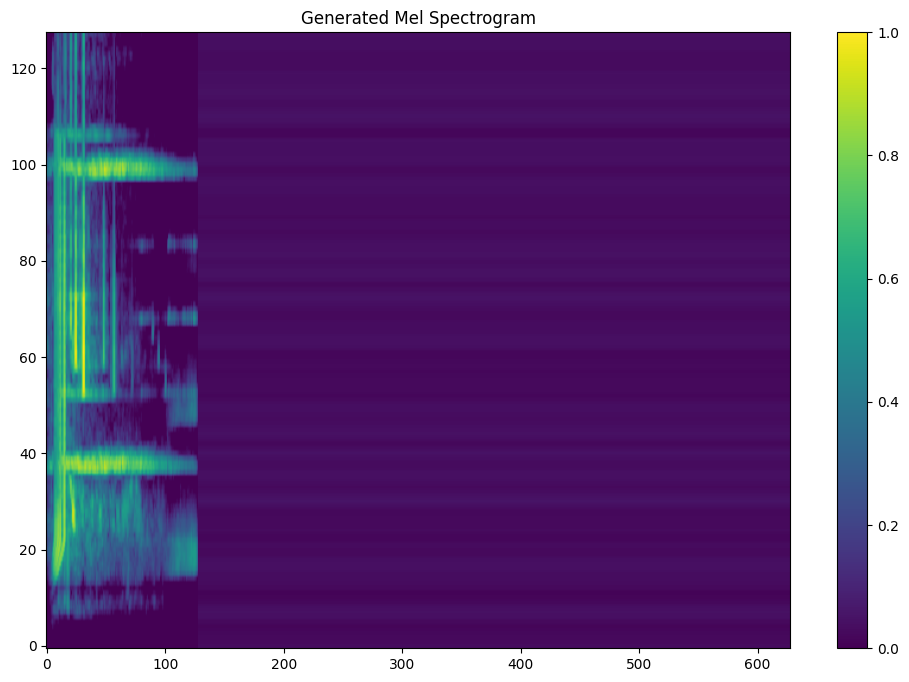

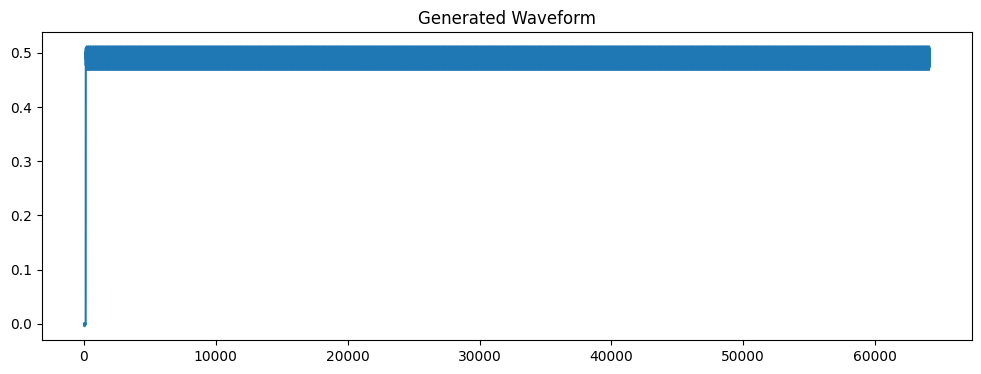

In [29]:
# Visualize results
plt.figure(figsize=(12, 8))
plt.imshow(generated_mel.T, aspect='auto', origin='lower')
plt.colorbar()
plt.title('Generated Mel Spectrogram')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(generated_wave)
plt.title('Generated Waveform')
plt.show()


In [30]:
# Convert generated mel spectrogram back to audio

def mel_to_audio(mel, sr=22050, n_iter=10):
    # Denormalize
    mel_db = mel * (mel.max() - mel.min()) + mel.min()
    # Convert to power spectrogram
    mel_power = librosa.db_to_power(mel_db)
    # Mel to frequency conversion
    return librosa.feature.inverse.mel_to_audio(mel_power, sr=sr, n_iter=n_iter)

# Convert generated mel to audio
generated_audio = mel_to_audio(generated_mel)

# Save the generated audio
sf.write('generated_continuation.wav', generated_audio, 22050)

print("Generated continuation saved as 'generated_continuation.wav'")

Generated continuation saved as 'generated_continuation.wav'


In [34]:
from playsound import playsound

In [46]:
import wave

print(f"Generated continuation saved as '{'generated_continuation.wav'}'")

# Inspect the generated WAV file
print("Inspecting generated audio file:")
with wave.open('generated_continuation.wav', 'rb') as wav_file:
    # Get basic information
    n_channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth()
    framerate = wav_file.getframerate()
    n_frames = wav_file.getnframes()

    # Calculate duration
    duration = n_frames / float(framerate)

    # Print information
    print(f"Number of channels: {n_channels}")
    print(f"Sample width: {sample_width} bytes")
    print(f"Frame rate: {framerate} Hz")
    print(f"Number of frames: {n_frames}")
    print(f"Duration: {duration:.2f} seconds")

# Print file size
file_size = os.path.getsize('generated_continuation.wav')
print(f"File size: {file_size / (1024 * 1024):.2f} MB")

print("\nThe WAV file has been generated successfully.")
print("To listen to the audio, you'll need to download the file and play it on your local machine.")

Generated continuation saved as 'generated_continuation.wav'
Inspecting generated audio file:
Number of channels: 1
Sample width: 2 bytes
Frame rate: 22050 Hz
Number of frames: 65024
Duration: 2.95 seconds
File size: 0.12 MB

The WAV file has been generated successfully.
To listen to the audio, you'll need to download the file and play it on your local machine.


Generated mel spectrogram shape: (628, 128)
Generated mel spectrogram min value: 0.0
Generated mel spectrogram max value: 1.0
Generated mel spectrogram mean value: 0.073748305

Generated waveform shape: (64128,)
Generated waveform min value: -0.0045167794
Generated waveform max value: 0.51190937
Generated waveform mean value: 0.4911914


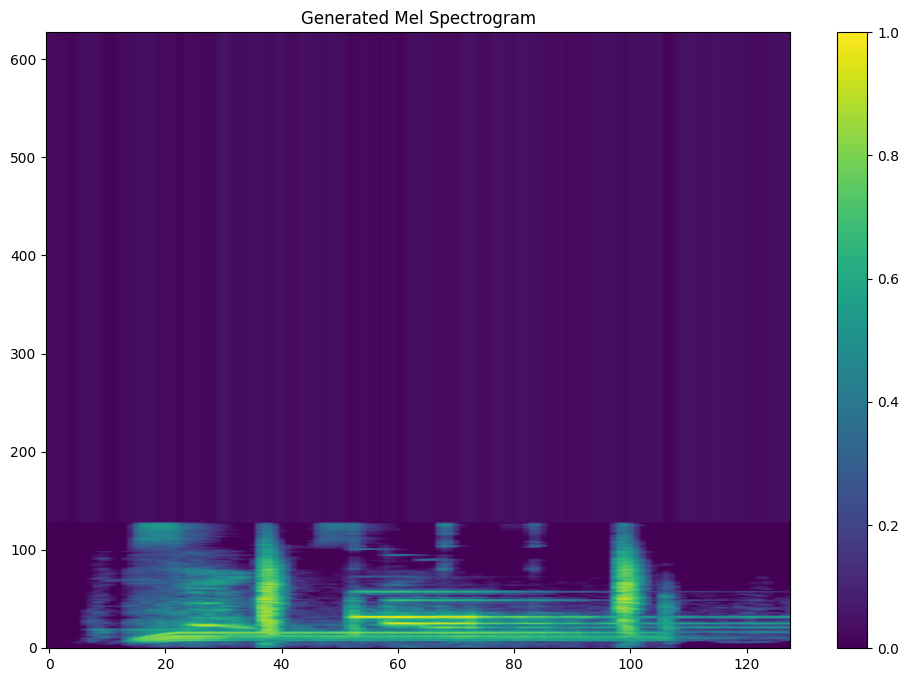

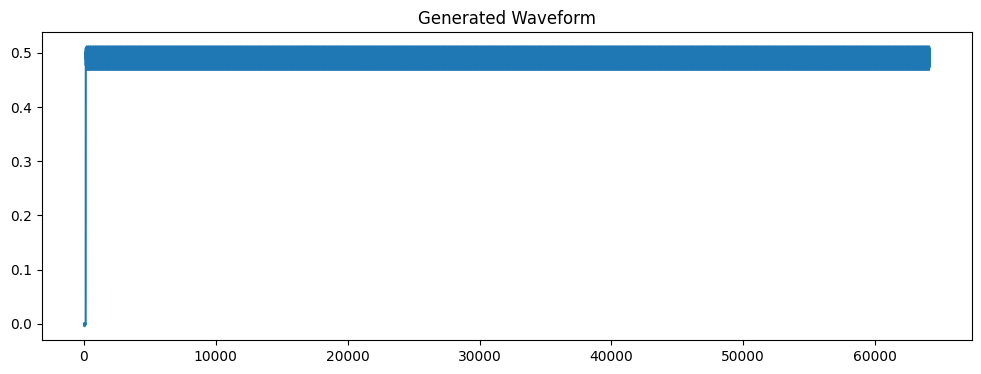

In [32]:
print("Generated mel spectrogram shape:", generated_mel.shape)
print("Generated mel spectrogram min value:", np.min(generated_mel))
print("Generated mel spectrogram max value:", np.max(generated_mel))
print("Generated mel spectrogram mean value:", np.mean(generated_mel))

print("\nGenerated waveform shape:", generated_wave.shape)
print("Generated waveform min value:", np.min(generated_wave))
print("Generated waveform max value:", np.max(generated_wave))
print("Generated waveform mean value:", np.mean(generated_wave))

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.imshow(generated_mel, aspect='auto', origin='lower')
plt.colorbar()
plt.title('Generated Mel Spectrogram')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(generated_wave)
plt.title('Generated Waveform')
plt.show()

Since we struggle a lot with the waveform, we will focus on the mel spectrogram and see if we can have a good results with that only

In [35]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, Conv2D, Flatten, Concatenate, Reshape, TimeDistributed
from tensorflow.keras.models import Model
from tqdm.keras import TqdmCallback
import librosa
import soundfile as sf
from tensorflow.keras.models import load_model

In [36]:
def process_audio(audio_path, duration=30, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
    # Load audio file
    y, sr = librosa.load(audio_path, duration=duration, sr=sr)

    # Compute mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalize spectrogram
    mel_spec_db = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min())

    return mel_spec_db

In [37]:
# Test the function

audio_file = "/content/DRAGANOV - 3DABI - OFFICIAL INSTRUMENTAL.mp3"
mel_spec = process_audio(audio_file)
print(f"Mel spectrogram shape: {mel_spec.shape}")

Mel spectrogram shape: (128, 1292)


Text(0.5, 1.0, '3dabi- Draganov Mel Spectrogram')

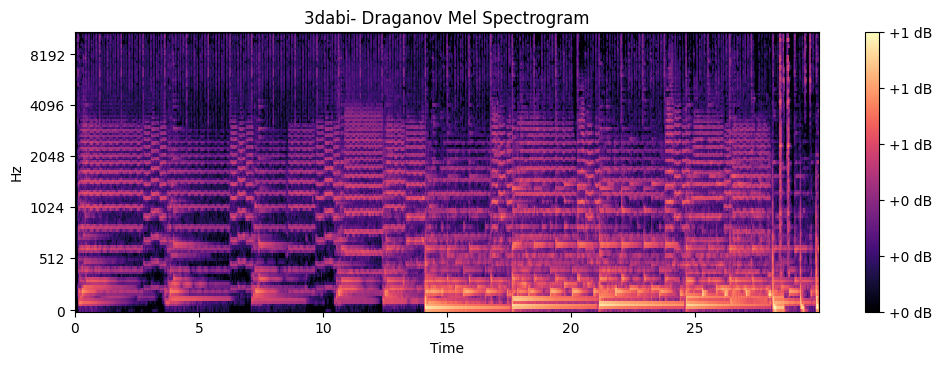

In [38]:
# Visualize

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
librosa.display.specshow(mel_spec, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('3dabi- Draganov Mel Spectrogram')

In [39]:
def process_audio_files(directory, max_files=None):
    processed_data = []
    audio_files = [f for f in os.listdir(directory) if f.endswith('.mp3') or f.endswith('.wav')]

    if max_files:
        audio_files = audio_files[:max_files]

    for audio_file in tqdm(audio_files, desc="Processing audio files"):
        file_path = os.path.join(directory, audio_file)
        mel_spec = process_audio(file_path)
        processed_data.append((mel_spec))

    return processed_data

In [40]:
# Creating the sequences for the model

def prepare_sequences(processed_data, seq_length=128):
    X_mel, y_mel = [], []

    for mel_spec in processed_data:
        for i in range(0, mel_spec.shape[1] - seq_length - 1, seq_length // 2):
            X_mel.append(mel_spec[:, i:i+seq_length])
            y_mel.append(mel_spec[:, i+1:i+seq_length+1])

    return np.array(X_mel), np.array(y_mel)

In [42]:
# Usage

audio_directory = "//content/draga-music"
processed_data = process_audio_files(audio_directory, max_files=10)  # Process up to 10 files
print(f"Processed {len(processed_data)} audio files")

Processing audio files: 100%|██████████| 8/8 [00:01<00:00,  4.60it/s]

Processed 8 audio files


In [44]:
# Usage

X_mel, y_mel = prepare_sequences(processed_data)
print(f"Input shapes: Mel - {X_mel.shape}")
print(f"Output shapes: Mel - {y_mel.shape}")

Input shapes: Mel - (152, 128, 128)
Output shapes: Mel - (152, 128, 128)


In [49]:
# Our NN model

def create_mel_only_hip_hop_model(mel_shape):
    mel_input = Input(shape=mel_shape, name='mel_input')

    x = Reshape((*mel_shape, 1))(mel_input)

    # Mel spectrogram processing
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)

    # LSTM layers
    x = Reshape((1, -1))(x)
    x = LSTM(64, return_sequences=True)(x)
    x = LSTM(64, return_sequences=True)(x)

    # Mel output
    mel_output = TimeDistributed(Dense(mel_shape[0] * mel_shape[1]))(x)
    mel_output = Reshape(mel_shape, name='mel_output')(mel_output)

    model = Model(inputs=mel_input, outputs=mel_output)
    return model

# Assuming our sequences are of length 128, and we have 128 mel frequency bands
mel_shape = (128, 128)

model = create_mel_only_hip_hop_model(mel_shape)
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mel_input (InputLayer)      [(None, 128, 128)]        0         
                                                                 
 reshape_8 (Reshape)         (None, 128, 128, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 16)      160       
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 flatten_5 (Flatten)         (None, 524288)            0         
                                                                 
 reshape_9 (Reshape)         (None, 1, 524288)         0         
                                                                 
 lstm_6 (LSTM)               (None, 1, 64)             1342

In [50]:
# Compile the model

model.compile(optimizer='adam', loss='mse')

In [51]:
batch_size = 16 # or even smaller, like 8 or 4

# Print data shapes
print("x_mel shape:", X_mel.shape)
print("y_mel shape:", y_mel.shape)


x_mel shape: (152, 128, 128)
y_mel shape: (152, 128, 128)


In [52]:
# Calculate the number of steps per epoch
steps_per_epoch = len(X_mel) // batch_size

# Use TqdmCallback for progress bar
tqdm_callback = TqdmCallback(verbose=0)  # verbose=0 to avoid double progress bars

history = model.fit(
    [X_mel],
    [y_mel],
    epochs=30,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=0,  # Set to 0 to avoid default progress bar
    callbacks=[tqdm_callback],
    steps_per_epoch=steps_per_epoch
)


0epoch [00:00, ?epoch/s]

In [53]:
# Save the model
model.save('compact_hip_hop_generator_v3.h5')
# v2 is improved on the wave side of the model and reducing natch size
# v3 focus only on the mel spec and remove everything related to waveform

# Print final training and validation losses
print("Final training loss:", history.history['loss'][-1])
print("Final validation loss:", history.history['val_loss'][-1])

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Final training loss: 0.023437196388840675
Final validation loss: 0.029436947777867317


In [59]:
def generate_continuation(model, initial_mel, num_steps=500):
    # Ensure the initial input is the correct shape
    if initial_mel.shape[1] > 128:
        input_segment = initial_mel[:, -128:]
    else:
        # If it's smaller, pad it
        padding = ((0, 0), (128 - initial_mel.shape[1], 0))
        input_segment = np.pad(initial_mel, padding, mode='constant')

    generated_mel = initial_mel.copy()  # Keep the full initial mel

    for _ in range(num_steps):
        input_segment = np.expand_dims(input_segment, axis=0)  # Add batch dimension
        predicted_segment = model.predict(input_segment, verbose=0)

        # Append only the last time step of the prediction
        new_timestep = predicted_segment[0, -1, :].reshape(128, 1)
        generated_mel = np.hstack([generated_mel, new_timestep])

        # Update input_segment for next iteration
        input_segment = generated_mel[:, -128:]

    return generated_mel

In [60]:
# Mel to audio conversion function
def mel_to_audio(mel, sr=22050, n_iter=10):
    # Ensure mel spectrogram is properly scaled
    if np.min(mel) < 0 or np.max(mel) > 1:
        mel = (mel - np.min(mel)) / (np.max(mel) - np.min(mel))

    # Convert to dB scale
    mel_db = librosa.power_to_db(mel, ref=np.max, top_db=80)

    # Invert to audio
    return librosa.feature.inverse.mel_to_audio(mel, sr=sr, n_iter=n_iter)

In [77]:
audio_file = '/content/Test-Maak.mp3'
initial_mel = process_audio(audio_file)

print("Initial mel shape:", initial_mel.shape)

# Generate continuation
generated_mel = generate_continuation(model, initial_mel, num_steps=500)

Initial mel shape: (128, 432)


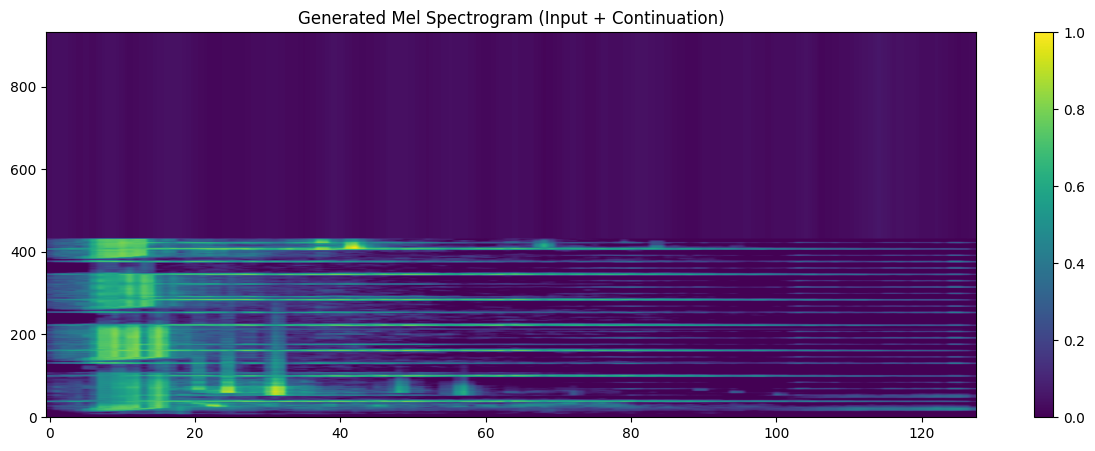

In [78]:
# Visualize
plt.figure(figsize=(15, 5))
plt.imshow(generated_mel.T, aspect='auto', origin='lower')
plt.colorbar()
plt.title('Generated Mel Spectrogram (Input + Continuation)')
plt.show()

In [63]:
# Convert to audio and save
generated_audio = mel_to_audio(generated_mel)
sf.write('generated_continuation.wav', generated_audio, 22050)
print("Generated continuation saved as 'generated_continuation.wav'")

Generated continuation saved as 'generated_continuation.wav'


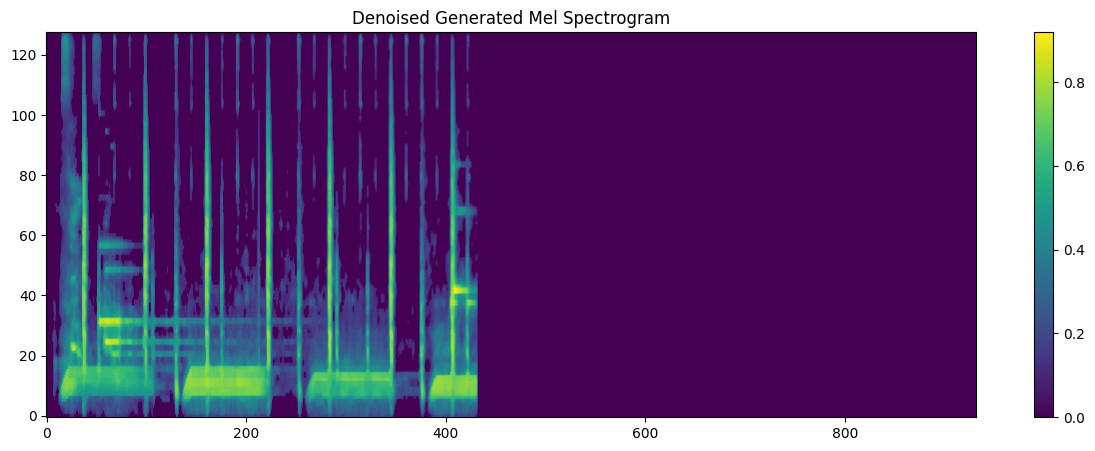

Denoised generated continuation saved as 'generated_continuation_denoised.wav'


In [64]:
from scipy import signal

def denoise_mel_spectrogram(mel_spec, threshold=0.1):
    # Apply a threshold to remove low-energy components
    mel_spec_denoised = np.where(mel_spec > threshold, mel_spec, 0)

    # Apply median filtering to smooth the spectrogram
    mel_spec_denoised = signal.medfilt2d(mel_spec_denoised, kernel_size=3)

    return mel_spec_denoised

# After generating the mel spectrogram
generated_mel_denoised = denoise_mel_spectrogram(generated_mel)

# Visualize the denoised spectrogram
plt.figure(figsize=(15, 5))
plt.imshow(generated_mel_denoised, aspect='auto', origin='lower')
plt.colorbar()
plt.title('Denoised Generated Mel Spectrogram')
plt.show()

# Convert denoised spectrogram to audio
generated_audio_denoised = mel_to_audio(generated_mel_denoised)
sf.write('generated_continuation_denoised.wav', generated_audio_denoised, 22050)
print("Denoised generated continuation saved as 'generated_continuation_denoised.wav'")

In [69]:
audio_file = '/content/Record (online-voice-recorder.com).mp3'
initial_mel = process_audio(audio_file)

print("Initial mel shape:", initial_mel.shape)

# Generate continuation
generated_mel = generate_continuation(model, initial_mel, num_steps=500)

Initial mel shape: (128, 287)


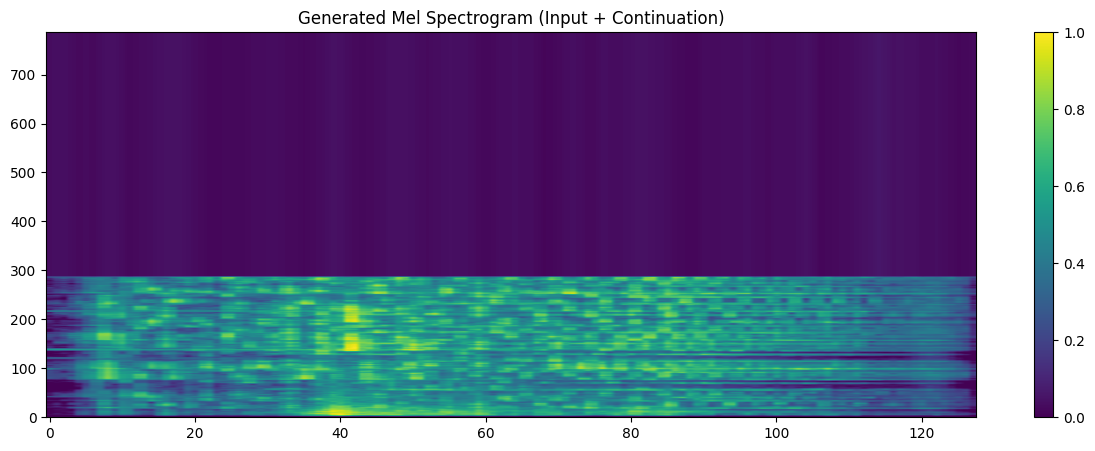

In [70]:
# Visualize
plt.figure(figsize=(15, 5))
plt.imshow(generated_mel.T, aspect='auto', origin='lower')
plt.colorbar()
plt.title('Generated Mel Spectrogram (Input + Continuation)')
plt.show()

In [71]:
# Convert to audio and save
generated_audio = mel_to_audio(generated_mel)
sf.write('generated_continuation_demipor.wav', generated_audio, 22050)
print("Generated continuation saved as 'generated_continuation.wav'")

Generated continuation saved as 'generated_continuation.wav'


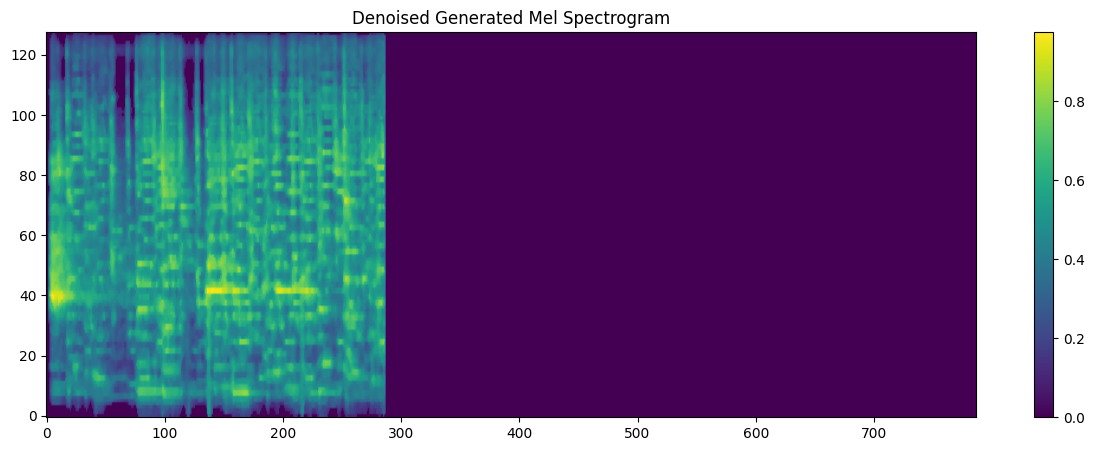

Denoised generated continuation saved as 'generated_continuation_denoised.wav'


In [72]:
# After generating the mel spectrogram
generated_mel_denoised = denoise_mel_spectrogram(generated_mel)

# Visualize the denoised spectrogram
plt.figure(figsize=(15, 5))
plt.imshow(generated_mel_denoised, aspect='auto', origin='lower')
plt.colorbar()
plt.title('Denoised Generated Mel Spectrogram')
plt.show()

# Convert denoised spectrogram to audio
generated_audio_denoised = mel_to_audio(generated_mel_denoised)
sf.write('generated_continuation_denoised_demipor.wav', generated_audio_denoised, 22050)
print("Denoised generated continuation saved as 'generated_continuation_denoised.wav'")

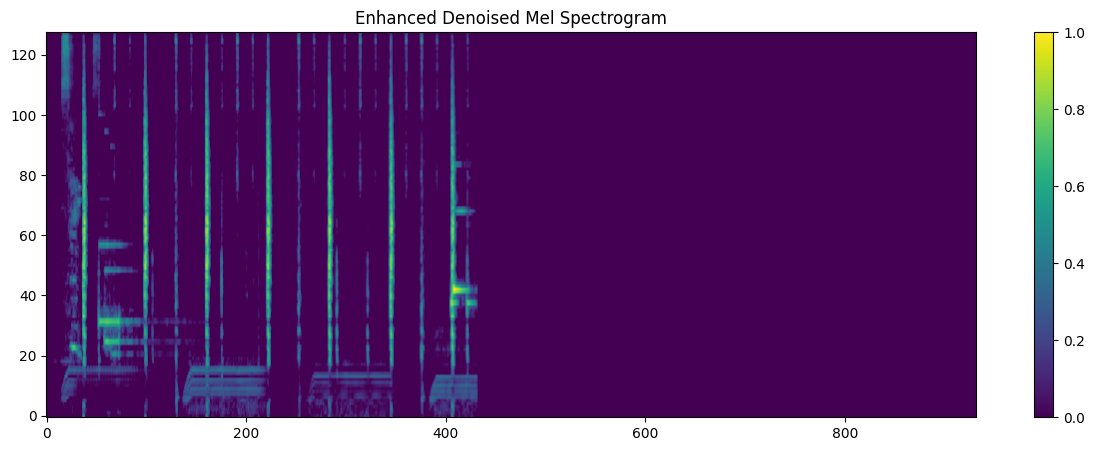

In [82]:
def enhanced_denoise_mel_spectrogram(mel_spec, noise_reduction_factor=2, median_kernel_size=3):
    # Step 1: Spectral Gating
    # Estimate noise floor
    noise_floor = np.mean(mel_spec, axis=1, keepdims=True) + np.std(mel_spec, axis=1, keepdims=True)

    # Apply spectral gate
    gated_spec = np.maximum(mel_spec - noise_floor * noise_reduction_factor, 0)

    # Step 2: Median Filtering
    filtered_spec = signal.medfilt2d(gated_spec, kernel_size=median_kernel_size)

    # Step 3: Spectral Subtraction
    mean_spectrum = np.mean(filtered_spec, axis=1, keepdims=True)
    noise_reduced_spec = np.maximum(filtered_spec - mean_spectrum * 0.5, 0)

    # Normalize the output
    normalized_spec = (noise_reduced_spec - noise_reduced_spec.min()) / (noise_reduced_spec.max() - noise_reduced_spec.min())

    return normalized_spec

# Apply the enhanced denoising to your generated mel spectrogram
denoised_mel = enhanced_denoise_mel_spectrogram(generated_mel, noise_reduction_factor=1, median_kernel_size=1)

# Visualize the denoised spectrogram
plt.figure(figsize=(15, 5))
plt.imshow(denoised_mel, aspect='auto', origin='lower')
plt.colorbar()
plt.title('Enhanced Denoised Mel Spectrogram')
plt.show()

In [83]:
# Convert denoised spectrogram to audio
denoised_audio = mel_to_audio(denoised_mel)
sf.write('enhanced_denoised_output.wav', denoised_audio, 22050)
print("Enhanced denoised output saved as 'enhanced_denoised_output.wav'")

Enhanced denoised output saved as 'enhanced_denoised_output.wav'
